In [213]:
!pip install xgboost
!pip install category_encoders

In [214]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import category_encoders as ce
from category_encoders import CatBoostEncoder
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [215]:
def data():
    df_train = pd.read_csv("spaceship-titanic/train.csv")
    df_test = pd.read_csv("spaceship-titanic/test.csv")
    return df_train, df_test

In [ ]:
def replace_outliers_with_median(df, multiplier=2.0):
    df_copy = df.copy()
    num_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

    for col in num_cols:
        if df_copy[col].isnull().all():
            print(f"{col}: all values are NaN, skipped")
            continue

        Q1 = df_copy[col].quantile(0.25)
        Q3 = df_copy[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - multiplier * IQR
        upper = Q3 + multiplier * IQR
        median = df_copy[col].median()

        outlier_mask = (df_copy[col] < lower) | (df_copy[col] > upper)
        outliers = outlier_mask.sum()

        df_copy.loc[outlier_mask, col] = median
        print(f"{col}: replaced {outliers} outliers with median ({median})")


## EDA

In [217]:
df_train, df_test = data()

In [218]:
print(df_train.info())
print(df_train.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
None
               Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  8514.000000   8512.000000   8510.000000   8485.00000

In [219]:
# 2. 缺失值比例
print(df_train.isnull().mean().sort_values(ascending=False))

CryoSleep       0.024963
ShoppingMall    0.023927
VIP             0.023352
HomePlanet      0.023122
Name            0.023007
Cabin           0.022892
VRDeck          0.021627
Spa             0.021051
FoodCourt       0.021051
Destination     0.020936
RoomService     0.020821
Age             0.020591
PassengerId     0.000000
Transported     0.000000
dtype: float64


HomePlanet
Earth     4602
Europa    2131
Mars      1759
Name: count, dtype: int64


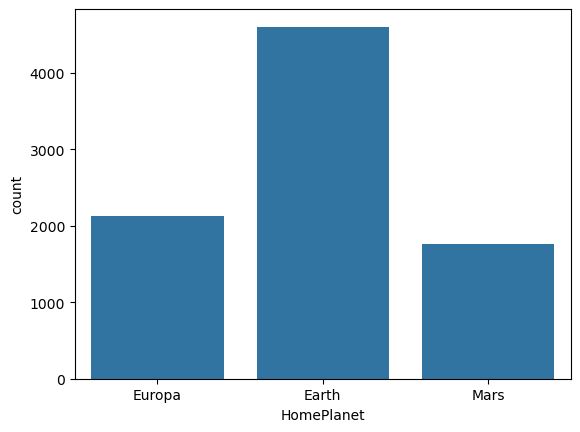

In [220]:
# 3. 類別欄位分佈
print(df_train['HomePlanet'].value_counts())
sns.countplot(x='HomePlanet', data=df_train)
plt.show()

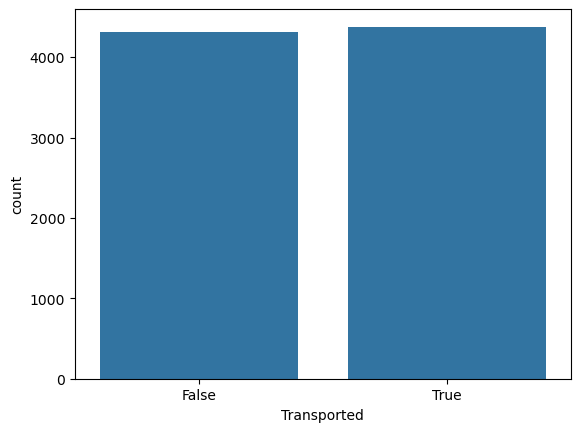

In [221]:
# 4. Transported 分佈
sns.countplot(x='Transported', data=df_train)
plt.show()

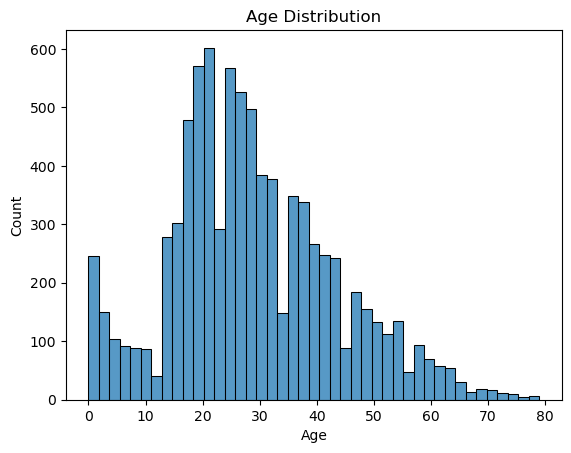

In [222]:
# 5. 年齡分佈
sns.histplot(df_train['Age'], kde=False)
plt.title("Age Distribution")
plt.show()

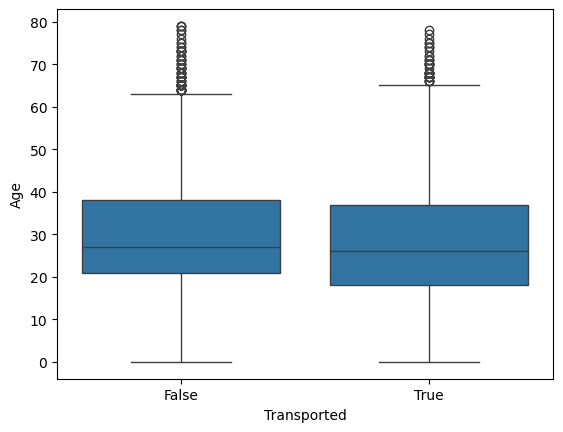

In [223]:
# 6. Age 與 Transported 的關聯
sns.boxplot(x='Transported', y='Age', data=df_train)
plt.show()

## RandomForest

### prepocessing 

In [224]:
df_train, df_test = data()

In [225]:
df_train['Age'].fillna(df_train['Age'].median(), inplace=True)
df_train['HomePlanet'].fillna(df_train['HomePlanet'].mode()[0], inplace=True)

/tmp/ipykernel_2098/201887349.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['Age'].fillna(df_train['Age'].median(), inplace=True)
/tmp/ipykernel_2098/201887349.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

In [226]:
df_test['Age'].fillna(df_test['Age'].median(), inplace=True)
df_test['HomePlanet'].fillna(df_test['HomePlanet'].mode()[0], inplace=True)

/tmp/ipykernel_2098/2779860767.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test['Age'].fillna(df_test['Age'].median(), inplace=True)
/tmp/ipykernel_2098/2779860767.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

In [227]:
df_train.drop(['Name', 'Cabin'], axis=1, inplace=True)
df_test.drop(['Name', 'Cabin'], axis=1, inplace=True)

### randomForest

In [228]:
df_train = pd.get_dummies(df_train, columns=['HomePlanet', 'Destination', 'CryoSleep', 'VIP'])
df_test = pd.get_dummies(df_test, columns=['HomePlanet', 'Destination', 'CryoSleep', 'VIP'])

In [229]:
X_train = df_train.drop('Transported', axis=1)
y_train = df_train['Transported'].astype(int)

In [230]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(df_test)
y_pred

array([1, 0, 1, ..., 1, 1, 0], shape=(4277,))

## XGBoost

### prepocessing

In [231]:
df_train, df_test = data()

In [232]:
df_train['Age'].fillna(df_train['Age'].median(), inplace=True)
df_train['HomePlanet'].fillna(df_train['HomePlanet'].mode()[0], inplace=True)

/tmp/ipykernel_2098/201887349.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['Age'].fillna(df_train['Age'].median(), inplace=True)
/tmp/ipykernel_2098/201887349.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

In [233]:
df_test['Age'].fillna(df_test['Age'].median(), inplace=True)
df_test['HomePlanet'].fillna(df_test['HomePlanet'].mode()[0], inplace=True)

/tmp/ipykernel_2098/2779860767.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test['Age'].fillna(df_test['Age'].median(), inplace=True)
/tmp/ipykernel_2098/2779860767.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

In [234]:
df_train.drop(['Name', 'Cabin'], axis=1, inplace=True)
df_test.drop(['Name', 'Cabin'], axis=1, inplace=True)

In [235]:
X_train = df_train.drop(columns=['PassengerId', 'Transported'])
y_train = df_train['Transported'].astype(int)
X_test = df_test.drop(columns=['PassengerId'])

In [236]:
print(X_train.head())
print(X_test.head())

  HomePlanet CryoSleep  Destination   Age    VIP  RoomService  FoodCourt  \
0     Europa     False  TRAPPIST-1e  39.0  False          0.0        0.0   
1      Earth     False  TRAPPIST-1e  24.0  False        109.0        9.0   
2     Europa     False  TRAPPIST-1e  58.0   True         43.0     3576.0   
3     Europa     False  TRAPPIST-1e  33.0  False          0.0     1283.0   
4      Earth     False  TRAPPIST-1e  16.0  False        303.0       70.0   

   ShoppingMall     Spa  VRDeck  
0           0.0     0.0     0.0  
1          25.0   549.0    44.0  
2           0.0  6715.0    49.0  
3         371.0  3329.0   193.0  
4         151.0   565.0     2.0  
  HomePlanet CryoSleep  Destination   Age    VIP  RoomService  FoodCourt  \
0      Earth      True  TRAPPIST-1e  27.0  False          0.0        0.0   
1      Earth     False  TRAPPIST-1e  19.0  False          0.0        9.0   
2     Europa      True  55 Cancri e  31.0  False          0.0        0.0   
3     Europa     False  TRAPPIST-1e

In [237]:
label_cols = ['HomePlanet', 'Destination', 'CryoSleep', 'VIP']

encoder = ce.CatBoostEncoder(cols=label_cols)
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test)


### XGBoost

In [238]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

/home/ahow/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:46:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [239]:
bool_pred = [bool(x) for x in y_pred]

submission = pd.DataFrame({
    "PassengerId": df_test["PassengerId"],
    "Transported": bool_pred
})

submission.to_csv("spaceship-titanic/submission.csv", index=False)

## Best model  

### prepocessing

In [253]:
df_train, df_test = data()

In [254]:
df_train['GroupId'] = df_train['PassengerId'].apply(lambda x: x.split('_')[0])
df_train['IsAlone'] = df_train['GroupId'].map(df_train['GroupId'].value_counts()) == 1
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,GroupId,IsAlone
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,True
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,True


In [255]:
df_test['GroupId'] = df_test['PassengerId'].apply(lambda x: x.split('_')[0])
df_test['IsAlone'] = df_test['GroupId'].map(df_test['GroupId'].value_counts()) == 1
df_test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,GroupId,IsAlone
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,0013,True
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,0018,True
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,0019,True
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,0021,True
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,0023,True


In [256]:
def split_cabin(cabin):
    if pd.isna(cabin):
        return pd.Series([None, None, None])
    parts = cabin.split('/')
    return pd.Series(parts if len(parts) == 3 else [None, None, None])

In [257]:
df_train[['CabinDeck', 'CabinNum', 'CabinSide']] = df_train['Cabin'].apply(split_cabin)
df_test[['CabinDeck', 'CabinNum', 'CabinSide']] = df_test['Cabin'].apply(split_cabin)
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,GroupId,IsAlone,CabinDeck,CabinNum,CabinSide
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,True,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,True,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,False,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,False,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,True,F,1,S


In [258]:
def preprocess(df, is_train=True, encoder=None):
    df = df.copy()

    # 👉 先合併消費欄位為 TotalSpending
    spend_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    df['TotalSpending'] = df[spend_cols].fillna(0).sum(axis=1)

    # 1️⃣ 補數值欄位缺值（含 CabinNum, Age, 以及剛剛加總的欄位）
    num_cols = ['Age', 'CabinNum'] + spend_cols
    for col in num_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')  # 確保為數值
        df[col] = df[col].fillna(df[col].median())

    # 2️⃣ 類別欄位補缺值（補眾數）
    cat_cols = ['HomePlanet', 'Destination', 'CryoSleep', 'VIP', 'CabinDeck', 'CabinSide', 'IsAlone']
    for col in cat_cols:
        df[col] = df[col].fillna(df[col].mode()[0])

    # 3️⃣ 類別欄位進行 CatBoostEncoding
    if is_train:
        encoder = CatBoostEncoder(cols=cat_cols)
        df[cat_cols] = encoder.fit_transform(df[cat_cols], df['Transported'].astype(int))
    else:
        df[cat_cols] = encoder.transform(df[cat_cols])

    return df, encoder

In [ ]:
df_train_processed, encoder = preprocess(df_train, is_train=True)
df_test_processed, _ = preprocess(df_test, is_train=False, encoder=encoder)

X_train = df_train_processed.drop(columns=['PassengerId', 'Name', 'Cabin', 'GroupId', 'Transported'])
y_train = df_train_processed['Transported'].astype(int)

X_test = df_test_processed.drop(columns=['PassengerId', 'Name', 'Cabin', 'GroupId'])

Age: removed 30 outliers
RoomService: removed 1839 outliers
FoodCourt: removed 1836 outliers
ShoppingMall: removed 1829 outliers
Spa: removed 1755 outliers
VRDeck: removed 1791 outliers


/tmp/ipykernel_2098/1004187078.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(df[col].mode()[0])
/tmp/ipykernel_2098/1004187078.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(df[col].mode()[0])


### predict

In [261]:
print(X_train.isnull().sum().sum())  # should be 0

0


In [262]:
voting_model = VotingClassifier(estimators=[
    ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")),
    ('rf', RandomForestClassifier()),
    ('lr', LogisticRegression(max_iter=1000))
], voting='soft')

In [263]:
voting_model.fit(X_train, y_train)

y_pred = voting_model.predict(X_test)

/home/ahow/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:48:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ahow/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [264]:
submission = pd.DataFrame({
    "PassengerId": df_test['PassengerId'],
    "Transported": [bool(x) for x in y_pred]
})
submission.to_csv("spaceship-titanic/submission.csv", index=False)
